<a href="https://colab.research.google.com/github/yuvalira/Adversarial-Attacks-Article/blob/main/models/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical Model — CatBoost**
CatBoost is a gradient-boosted decision tree library optimized for **tabular data** with strong support for **categorical features**.
It uses *ordered boosting* to reduce overfitting, handles **categoricals natively** (no one-hot), and delivers excellent performance with minimal tuning.

References:
- [CatBoost docs](https://catboost.ai/)
- [catboost.CatBoostClassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

## Imports & setup

In [1]:
!pip -q install -U catboost scikit-learn huggingface_hub

import os, time, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

from catboost import CatBoostClassifier, Pool

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 32.4 MB/s eta 0:00:00


## Load splits from HF

In [2]:
repo_id   = "yuvalira/adult_income_balanced"  # TODO
repo_type = "dataset"

def read_split_csv(repo_id, filename, repo_type="dataset"):
    p = hf_hub_download(repo_id=repo_id, filename=filename, repo_type=repo_type, token=False)
    return pd.read_csv(p)

train_data = read_split_csv(repo_id, "train.csv", repo_type)
val_data   = read_split_csv(repo_id, "val.csv",   repo_type)

print("Train:", train_data.shape, "| Val:", val_data.shape)
display(train_data.head(3))

train.csv: 0.00B [00:00, ?B/s]

val.csv: 0.00B [00:00, ?B/s]

Train: (11687, 14) | Val: (2337, 14)


,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,36,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,>50K
1,37,Self-emp-not-inc,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,55,United-States,<=50K
2,54,Private,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,1848,40,United-States,>50K


## Column discovery & config

In [3]:
auto_num = train_data.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns.tolist()
auto_cat = train_data.select_dtypes(include=['object','category','bool']).columns.tolist()

TARGET_COLUMN_NAME   = "income"               # TODO
TARGET_LABELS        = ["<=50K", ">50K"]      # TODO (order defines ids)
SAMPLE_WEIGHT_COLUMN = None                   # or "weight"

FEATURE_COLUMNS = [c for c in train_data.columns if c != TARGET_COLUMN_NAME]  # keep original order
CATEGORICAL_FEATURE_NAMES = [c for c in auto_cat if c != TARGET_COLUMN_NAME]
NUMERIC_FEATURE_NAMES     = [c for c in auto_num if c != TARGET_COLUMN_NAME]

print("Numeric:", NUMERIC_FEATURE_NAMES)
print("Categorical:", CATEGORICAL_FEATURE_NAMES)

Numeric: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


## Prepare dataframes (map target, ensure categoricals are strings)

In [4]:
train_data = train_data.copy()
val_data   = val_data.copy()

label2id = {lbl:i for i,lbl in enumerate(TARGET_LABELS)}
id2label = {i:lbl for lbl,i in label2id.items()}

def prepare_df(df):
    assert TARGET_COLUMN_NAME in df.columns, f"No target '{TARGET_COLUMN_NAME}'"
    df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(label2id)
    if df[TARGET_COLUMN_NAME].isna().any():
        bad = df.loc[df[TARGET_COLUMN_NAME].isna(), TARGET_COLUMN_NAME].unique().tolist()
        raise ValueError(f"Unmapped targets: {bad} vs {TARGET_LABELS}")
    # CatBoost expects categoricals as strings/object
    for c in CATEGORICAL_FEATURE_NAMES:
        if c in df.columns:
            df[c] = df[c].astype(str)
    return df

prepare_df(train_data); prepare_df(val_data)

n_classes = int(train_data[TARGET_COLUMN_NAME].nunique())
avg_mode = None if n_classes==2 else "macro"
print("Classes:", [id2label[i] for i in sorted(train_data[TARGET_COLUMN_NAME].unique())])

Classes: ['<=50K', '>50K']


## Build CatBoost Pools (native categorical handling)

In [5]:
X_train = train_data[FEATURE_COLUMNS]
y_train = train_data[TARGET_COLUMN_NAME].values

X_val   = val_data[FEATURE_COLUMNS]
y_val   = val_data[TARGET_COLUMN_NAME].values

# CatBoost needs cat feature indices (0-based positions) in the **feature matrix**
cat_features_idx = [X_train.columns.get_loc(c) for c in CATEGORICAL_FEATURE_NAMES]

sample_weight_train = train_data[SAMPLE_WEIGHT_COLUMN].values if SAMPLE_WEIGHT_COLUMN else None
sample_weight_val   = val_data[SAMPLE_WEIGHT_COLUMN].values   if SAMPLE_WEIGHT_COLUMN else None

pool_train = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features_idx,
    weight=sample_weight_train
)
pool_val = Pool(
    data=X_val,
    label=y_val,
    cat_features=cat_features_idx,
    weight=sample_weight_val
)

print("Cat features indices:", cat_features_idx)

Cat features indices: [1, 2, 4, 5, 6, 7, 8, 12]


## Define model (reasonable defaults) + train with early stopping

In [6]:
# For GPU (optional): add task_type="GPU", devices="0"
params = dict(
    loss_function = "Logloss" if n_classes==2 else "MultiClass",
    eval_metric   = "AUC" if n_classes==2 else "MultiClass",
    learning_rate = 0.05,
    depth         = 8,
    l2_leaf_reg   = 3.0,
    iterations    = 2000,           # with early stopping
    random_seed   = RANDOM_STATE,
    verbose       = 200,
    allow_writing_files = False,     # keep workspace clean
    task_type = "GPU",
    devices = "0"
)

model_cb = CatBoostClassifier(**params)

t0 = time.time()
model_cb.fit(
    pool_train,
    eval_set=pool_val,
    use_best_model=True,
    early_stopping_rounds=100
)
print(f"Training time: {time.time()-t0:.2f}s")
print("Best iteration:", model_cb.best_iteration_)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8978788	best: 0.8978788 (0)	total: 246ms	remaining: 8m 12s
200:	test: 0.9255800	best: 0.9255800 (200)	total: 29.2s	remaining: 4m 21s
400:	test: 0.9287219	best: 0.9287219 (399)	total: 48.8s	remaining: 3m 14s
bestTest = 0.9290698171
bestIteration = 465
Shrink model to first 466 iterations.
Training time: 64.97s
Best iteration: 465


## Evaluate

In [7]:
y_pred = model_cb.predict(X_val)                 # class ids
y_pred = y_pred.astype(int).ravel()              # ensure shape

# Probabilities for ROC/AUC
if n_classes == 2:
    y_prob = model_cb.predict_proba(X_val)[:, 1]
else:
    y_prob = model_cb.predict_proba(X_val)       # shape (N, K)

def metrics(y_true, y_pred, y_prob=None, average=None):
    acc = accuracy_score(y_true, y_pred)
    if average is None:
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
    else:
        prec = precision_score(y_true, y_pred, average=average, zero_division=0)
        rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
        f1   = f1_score(y_true, y_pred, average=average, zero_division=0)
    out = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1}
    if y_prob is not None:
        try:
            if n_classes==2:
                out["roc_auc"] = roc_auc_score(y_true, y_prob)
            else:
                out["roc_auc"] = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
        except Exception:
            pass
    return out

res = metrics(y_val, y_pred, y_prob, average=avg_mode)
print("Validation metrics:", {k: round(v,4) for k,v in res.items()})

print("\nClassification report (val):")
print(classification_report(y_val, y_pred, target_names=[id2label[i] for i in range(n_classes)], zero_division=0))
print("Confusion matrix (val):")
print(confusion_matrix(y_val, y_pred))

Validation metrics: {'accuracy': 0.8438, 'precision': 0.8174, 'recall': 0.8853, 'f1': 0.85, 'roc_auc': 0.9291}

Classification report (val):
              precision    recall  f1-score   support

       <=50K       0.88      0.80      0.84      1169
        >50K       0.82      0.89      0.85      1168

    accuracy                           0.84      2337
   macro avg       0.85      0.84      0.84      2337
weighted avg       0.85      0.84      0.84      2337

Confusion matrix (val):
[[ 938  231]
 [ 134 1034]]


ROC Curve

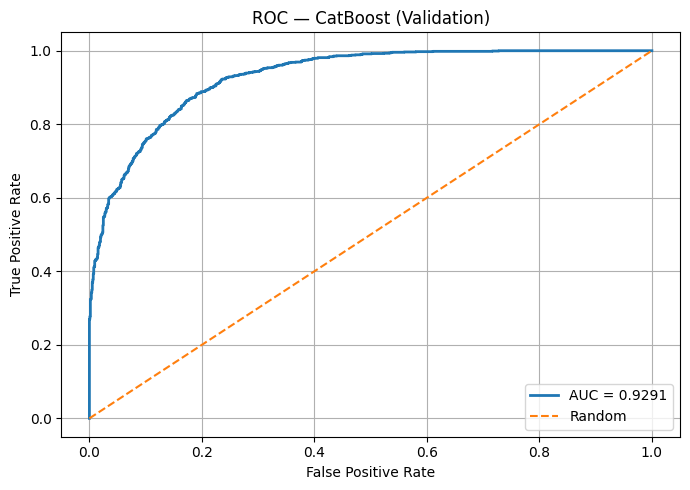

In [8]:
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
    plt.plot([0,1],[0,1],'--', label="Random")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — CatBoost (Validation)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Multiclass ROC: compute micro/macro as needed.")

## Save model + metadata (both native .cbm and a joblib bundle)

In [9]:
import joblib

os.makedirs("models", exist_ok=True)
safe_repo_id = re.sub(r'[^A-Za-z0-9_.-]+', '_', repo_id)

# Native CatBoost binary (recommended if you’ll load with CatBoost)
cbm_path = f"models/CatBoost_model_{safe_repo_id}.cbm"
model_cb.save_model(cbm_path)
print("Saved CatBoost binary:", os.path.abspath(cbm_path))

# Also save a small bundle with metadata you might need later
bundle = {
    "model_path_cbm": cbm_path,
    "target_name": TARGET_COLUMN_NAME,
    "label2id": label2id,
    "id2label": id2label,
    "feature_order": FEATURE_COLUMNS,
    "categorical_features": CATEGORICAL_FEATURE_NAMES,
    "cat_feature_indices": cat_features_idx
}
joblib_path = f"models/CatBoost_bundle_{safe_repo_id}.joblib"
joblib.dump(bundle, joblib_path)
print("Saved bundle:", os.path.abspath(joblib_path))

Saved CatBoost binary: /content/models/CatBoost_model_yuvalira_adult_income_balanced.cbm
Saved bundle: /content/models/CatBoost_bundle_yuvalira_adult_income_balanced.joblib
